# Ajuste de las curvas obtenidas en el transitorio del circuito RL

En este tutorial analizo los datos adquiridos de un circuito RL transitorio.

El circuito tiene las siguientes caracteristicas:

```
 _____ -V0 (PULSE)+ _____ R _____ L ____   
|                     |       |         |  
GND                  Vin     VL         GND
```

Parámetros:
- L = 100 $mH$
- R = 100 $\Omega$
- Tiempo característico $\tau = L/R \approx 0.001$ sec
- $V_0$ tren de pulsos cuadrados, tension en alto $5V$. Tiempo de alto y tiempo de bajo $10\tau$
- En $V_{in}$ se mide la señal de entrada respecto de GND (masa).
- En $V_L$ se mide la tensión en el inductor respecto de GND (masa).


Empezamos importando las librerías necesarias:

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

Cargamos los datos, y hacemos una exploración inicial:

In [20]:
df = pd.read_csv("datos/data_RL.csv")

df.head()

,time,Vin,VL,I
0,0.000000e+00,-0.005661,0.004707,-0.000116
1,1.428571e-10,0.711912,0.698744,0.000158
2,2.857143e-10,1.425333,1.418161,-0.000028
3,4.285714e-10,2.133674,2.135949,0.000040
4,5.714286e-10,2.856948,2.854114,0.000129


<Axes: xlabel='time'>

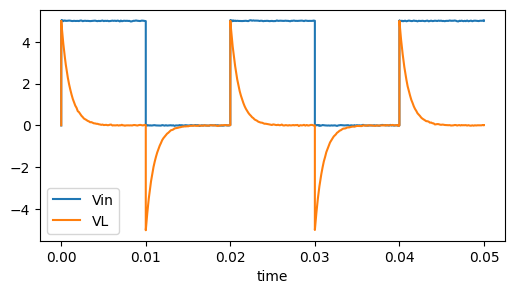

In [ ]:
df.plot(x="time", y=["Vin", "VL"], kind="line", figsize=(6, 3))     # gráfico exploratorio

### Ajuste RL - Pulso en alto

Vamos a utilizar uno de los pulsos para ajustar la corriente y la tensión en el inductor en cuando el pulso esta en alto.

Supongamos que queremos ajustar el ultimo pulso, el que va desde $t=0.04$ a $t=0.05$. En primer lugar tenemos que tomar los datos que solo estan en esa parte de la curva, hacemos un filtrado:

In [22]:
# Defino un tiempo inicial y uno final para el filtro
t1 = 0.04                
t2 = 0.05

# filtro los datos
df_carga = df[ (df["time"]>t1) & (df["time"]<t2) ]

El dataframe *df_carga* contiene solo la parte de la curva que nos interesa. Para checkear que tomamos los datos correctamente, utilizamos la rutina plot de pandas para hacer una inspección visual rápida:

<Axes: xlabel='time'>

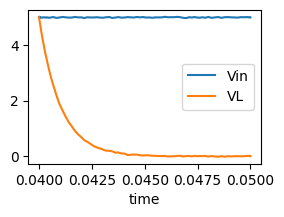

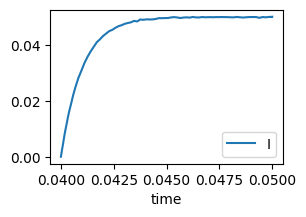

In [23]:
df_carga.plot(x="time", y=["Vin", "VL"], kind="line", figsize=(3, 2))

df_carga.plot(x="time", y="I", kind="line", figsize=(3, 2))

Como vemos el filtro funcionó correctamente.

Ahora, note que en el eje x el *tiempo cero* quedo dezplazado. Transformo los datos para que vayan desde $t=0$ a $t=0.01$, esto es un paso previo necesario para luego ejecutar correctamente el ajuste no lineal:

In [24]:
t0 = df_carga["time"].iloc[0]                   # toma el primer dato
t  = df_carga["time"].to_numpy()- t0            # se lo resta a todo el array

VL = df_carga["VL"].to_numpy()   

Note que al mismo tiempo ya pasamos los datos a *numpy array* para mayor comodidad.

Con esto ya podemos hacer el ajuste, primero proponemos el modelo y las semillas (valores aproximados de los parámetros que ayudan al algoritmo a converger más rápido):

In [25]:
def modelo_tension(u, V0, tau):                         # Ec para la tensión VL en el la carga
    z= V0*np.exp(-u/tau)
    return z

V0_ini  = 1
tau_ini = 1e-3

Ahora ajustamos con *curve fit* para obtener los parámetros:

In [26]:
popt, pcov = curve_fit(modelo_tension, t, VL, p0=[ V0_ini, tau_ini ] )      

V0, tau = popt

# Errores 
error_V0, error_tau = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"V_0 = ({V0:.4f} ± {error_V0:.4f})")
print(f"tau = ({tau:.6f} ± {error_tau:.6f})")

Parámetros obtenidos del ajuste:
V_0 = (4.9956 ± 0.0031)
tau = (0.001001 ± 0.000002)


Graficamos datos + ajuste:

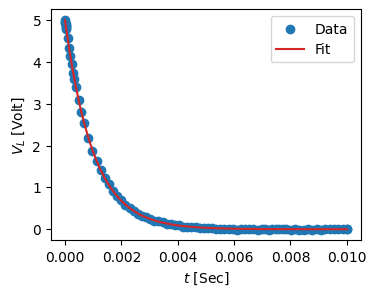

In [30]:
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, VL ,label='Data')                                    # datos

ax.plot( t, modelo_tension(t, V0, tau), c='C3', label='Fit' )       # modelo con parametros del ajuste

ax.set_xlabel("$t$ [Sec]")
ax.set_ylabel("$V_L$ [Volt]")

plt.legend(loc=1)
plt.show()




Ahora hacemos lo mismo pero para la corriente:

Parámetros obtenidos del ajuste:
I_0 = (0.050001810 ± 0.000015160)
tau = (0.001000938 ± 0.000001685)


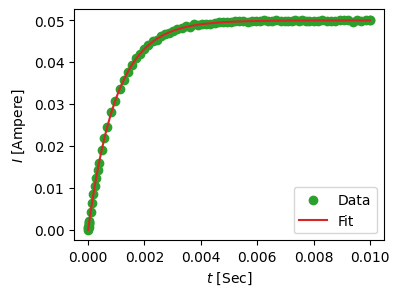

In [31]:
# Tomo data
t0 = df_carga["time"].iloc[0]
t  = df_carga["time"].to_numpy()- t0

I = df_carga["I"].to_numpy()    


# Ec para la tensión VC en el la carga
def modelo_corriente(u, I0, tau):                         
    z= I0*(1-np.exp(-u/tau))
    return z

# semillas
I0_ini  = 0.01            
tau_ini = 1e-3

# ajuste
popt, pcov = curve_fit(modelo_corriente, t, I, p0=[ I0_ini,tau_ini ] )      

# param del ajuste
I0, tau = popt

# Errores
error_I0, error_tau = np.sqrt(np.diag(pcov))

print ("Parámetros obtenidos del ajuste:")
print(f"I_0 = ({I0:.9f} ± {error_I0:.9f})")
print(f"tau = ({tau:.9f} ± {error_tau:.9f})")


# Gráfico
fig,ax = plt.subplots(figsize=(4,3))

ax.scatter( t, I ,label='Data', c='C2')

ax.plot( t, modelo_corriente(t, I0, tau), c='C3', label='Fit' )

ax.set_xlabel("$t$ [Sec]")
ax.set_ylabel("$I$ [Ampere]")
plt.legend(loc=4)
plt.show()
